In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from sklearn.cluster import KMeans
import copy

import sys
sys.path.append("lib")

import lib

import torch
torch.set_default_dtype(torch.float64)

from functorch import vmap
from torch.utils.data import DataLoader
import tqdm

/home/peiyi/mambaforge3/envs/rom/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device("cuda")

In [3]:
coords_x, coords_y, _ = lib.utils.read_coords("2d_burger_data/time_step_0.csv")
coords = torch.stack((coords_x, coords_y), dim=1)
N = coords.shape[0]

In [4]:
dt = 0.002
S = 1001

u = lib.utils.read_data(S, N, '2d_burger_data/time_step_', 'vel_0')
u = u[500:601]
u.shape

torch.Size([101, 14641])

In [5]:
u_dot = lib.utils.u_dot(u, dt)
u = u[:-1]

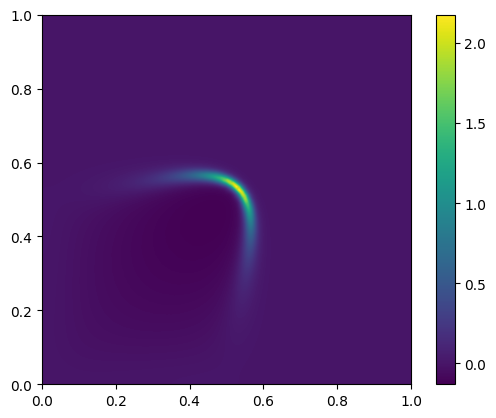

In [6]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import griddata

# data coordinates and values
x = coords_x.tolist()
y = coords_y.tolist()
z = u_dot[55].tolist()

# target grid to interpolate to
xi = yi = np.linspace(0,1.0,1200)
xi,yi = np.meshgrid(xi,yi)

# set mask
# mask = (xi > 0.5) & (xi < 0.6) & (yi > 0.5) & (yi < 0.6)

# interpolate
zi = griddata((x,y),z,(xi,yi),method='cubic')

plt.imshow(zi,origin='lower', extent=[0,1,0,1])
plt.colorbar()

In [7]:
m = 50
clustering = KMeans(n_clusters=m, random_state=0, n_init="auto").fit(coords)

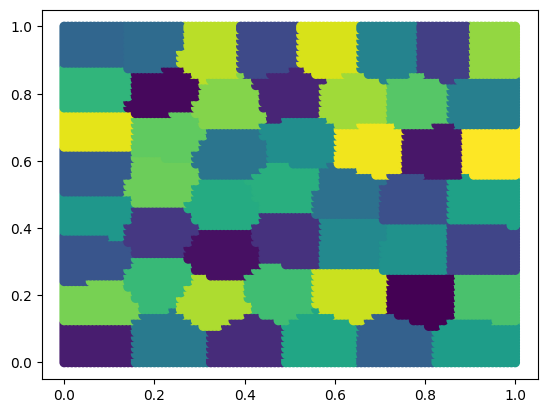

In [8]:
plt.scatter(coords_x, coords_y,c=clustering.labels_)

In [9]:
n = 20
# fixed support (length)
mu = int(np.ceil(N/100))
neighbour_distance, neighbour_id = lib.utils.topk_neighbours(coords, mu)

In [10]:
batch_size = 8
u = u.to(device)
u_dot = u_dot.to(device)
dataset = torch.utils.data.TensorDataset(u, u_dot)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [11]:
ed = lib.nrbs_hot_map.EncoderDecoder(N=N, n=n, mu=mu, m=[100, m], B0=1/60, neighbour_id=neighbour_id, neighbour_distance=neighbour_distance, clustering_labels=torch.tensor(clustering.labels_).type(torch.LongTensor), device=device)

In [12]:
ed.train(dataloader, effective_batch=100, epochs=1000)

100%|██████████| 13/13 [00:01<00:00,  6.79it/s]


Initial loss = 3105.7833197562254


100%|██████████| 13/13 [00:01<00:00,  7.76it/s]


Itr 0, curr_loss = 592.6858407495355, best_loss = 592.6858407495355


100%|██████████| 13/13 [00:01<00:00,  7.36it/s]


Itr 1, curr_loss = 384.9567173225869, best_loss = 384.9567173225869


100%|██████████| 13/13 [00:01<00:00,  7.25it/s]


Itr 2, curr_loss = 240.0903818977702, best_loss = 240.0903818977702


100%|██████████| 13/13 [00:01<00:00,  7.15it/s]


Itr 3, curr_loss = 128.5551374198797, best_loss = 128.5551374198797


100%|██████████| 13/13 [00:01<00:00,  7.22it/s]


Itr 4, curr_loss = 98.16544041474438, best_loss = 98.16544041474438


100%|██████████| 13/13 [00:01<00:00,  7.71it/s]


Itr 5, curr_loss = 87.75448967750614, best_loss = 87.75448967750614


100%|██████████| 13/13 [00:01<00:00,  7.18it/s]


Itr 6, curr_loss = 78.25159406747527, best_loss = 78.25159406747527


100%|██████████| 13/13 [00:01<00:00,  7.36it/s]


Itr 7, curr_loss = 69.16058168265529, best_loss = 69.16058168265529


100%|██████████| 13/13 [00:01<00:00,  7.15it/s]


Itr 8, curr_loss = 59.478974917364276, best_loss = 59.478974917364276


100%|██████████| 13/13 [00:01<00:00,  7.06it/s]


Itr 9, curr_loss = 56.34740638596986, best_loss = 56.34740638596986


100%|██████████| 13/13 [00:01<00:00,  7.19it/s]


Itr 10, curr_loss = 50.82310746909223, best_loss = 50.82310746909223


100%|██████████| 13/13 [00:01<00:00,  7.12it/s]


Itr 11, curr_loss = 47.54364882639405, best_loss = 47.54364882639405


100%|██████████| 13/13 [00:01<00:00,  7.02it/s]


Itr 12, curr_loss = 45.561796087925195, best_loss = 45.561796087925195


100%|██████████| 13/13 [00:01<00:00,  7.07it/s]


Itr 13, curr_loss = 43.724281719082406, best_loss = 43.724281719082406


100%|██████████| 13/13 [00:01<00:00,  7.26it/s]


Itr 14, curr_loss = 42.901919927458565, best_loss = 42.901919927458565


100%|██████████| 13/13 [00:01<00:00,  7.20it/s]


Itr 15, curr_loss = 41.88485502971121, best_loss = 41.88485502971121


100%|██████████| 13/13 [00:01<00:00,  7.28it/s]


Itr 16, curr_loss = 40.56376411580863, best_loss = 40.56376411580863


100%|██████████| 13/13 [00:01<00:00,  7.56it/s]


Itr 17, curr_loss = 39.905780993779416, best_loss = 39.905780993779416


100%|██████████| 13/13 [00:01<00:00,  7.64it/s]


Itr 18, curr_loss = 38.96009996128987, best_loss = 38.96009996128987


100%|██████████| 13/13 [00:01<00:00,  7.13it/s]


Itr 19, curr_loss = 38.01550021275388, best_loss = 38.01550021275388


100%|██████████| 13/13 [00:01<00:00,  7.12it/s]


Itr 20, curr_loss = 37.214857515183176, best_loss = 37.214857515183176


100%|██████████| 13/13 [00:01<00:00,  7.24it/s]


Itr 21, curr_loss = 36.553490488769015, best_loss = 36.553490488769015


100%|██████████| 13/13 [00:01<00:00,  7.21it/s]


Itr 22, curr_loss = 35.56458446869873, best_loss = 35.56458446869873


100%|██████████| 13/13 [00:01<00:00,  7.30it/s]


Itr 23, curr_loss = 34.818722115389804, best_loss = 34.818722115389804


100%|██████████| 13/13 [00:01<00:00,  7.59it/s]


Itr 24, curr_loss = 34.170113260673766, best_loss = 34.170113260673766


100%|██████████| 13/13 [00:01<00:00,  7.63it/s]


Itr 25, curr_loss = 33.244999944186276, best_loss = 33.244999944186276


100%|██████████| 13/13 [00:01<00:00,  7.57it/s]


Itr 26, curr_loss = 32.524753499584996, best_loss = 32.524753499584996


100%|██████████| 13/13 [00:01<00:00,  7.26it/s]


Itr 27, curr_loss = 31.96976350132076, best_loss = 31.96976350132076


100%|██████████| 13/13 [00:01<00:00,  7.29it/s]


Itr 28, curr_loss = 31.400767545240516, best_loss = 31.400767545240516


100%|██████████| 13/13 [00:01<00:00,  7.31it/s]


Itr 29, curr_loss = 30.613096808868004, best_loss = 30.613096808868004


100%|██████████| 13/13 [00:01<00:00,  7.35it/s]


Itr 30, curr_loss = 29.81762805281946, best_loss = 29.81762805281946


100%|██████████| 13/13 [00:01<00:00,  7.07it/s]


Itr 31, curr_loss = 29.482450528126762, best_loss = 29.482450528126762


100%|██████████| 13/13 [00:01<00:00,  7.63it/s]


Itr 32, curr_loss = 28.787242520321975, best_loss = 28.787242520321975


100%|██████████| 13/13 [00:01<00:00,  7.27it/s]


Itr 33, curr_loss = 27.913960420589827, best_loss = 27.913960420589827


100%|██████████| 13/13 [00:01<00:00,  7.20it/s]


Itr 34, curr_loss = 26.656577820068694, best_loss = 26.656577820068694


100%|██████████| 13/13 [00:01<00:00,  7.23it/s]


Itr 35, curr_loss = 26.20523306954234, best_loss = 26.20523306954234


100%|██████████| 13/13 [00:01<00:00,  7.30it/s]


Itr 36, curr_loss = 25.722937356053155, best_loss = 25.722937356053155


 92%|█████████▏| 12/13 [02:26<00:12, 12.18s/it]


KeyboardInterrupt: 